In [254]:
import collections

import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
import torchtext
from tqdm import tqdm
# import tqdm
import os
from torch.utils.data import Dataset, DataLoader, random_split
import seaborn as sns


In [4]:
seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

# Load dataset

In [5]:
root = os.getcwd()
dataset_path = os.path.join(root, 'dataset', 'aclImdb')
assert os.path.exists(dataset_path), f'dataset path does not exist {dataset_path}'

train_dataset_path = os.path.join(root, 'dataset', 'aclImdb', 'train')
assert os.path.exists(train_dataset_path), f'train path does not exist {train_dataset_path}'
test_dataset_path = os.path.join(root, 'dataset', 'aclImdb', 'test')
assert os.path.exists(test_dataset_path), f'test path does not exist {test_dataset_path}'

In [61]:
def load_aclImbd_dataset(dataset_root):
    train_root = os.path.join(dataset_root, 'train')
    print('train path = ', train_root)
    test_root = os.path.join(dataset_root, 'test')
    print('test path = ', test_root)
    X_train = []
    y_train = []

    #build train dataset
    print('building train dataset')
    for label in ['neg', 'pos']:
        path = os.path.join(train_root, label)

        for file in tqdm(os.listdir(path)):
            if file.endswith('.txt'):
                with open(os.path.join(path, file), 'r') as reader:
                    text = reader.read()
                    X_train.append(text)
                    y_train.append(label)
    
    X_test = []
    y_test = []

    print('building test dataset')
    for label in ['neg', 'pos']:
        path = os.path.join(test_root, label)

        for file in tqdm(os.listdir(path)):
            if file.endswith('.txt'):
                with open(os.path.join(path, file), 'r') as reader:
                    text = reader.read()
                    X_test.append(text)
                    y_test.append(label)

    return X_train, y_train, X_test, y_test
    
feature_train, label_train, feature_test, label_test = load_aclImbd_dataset(dataset_path)

train path =  e:\ML\NLP\UB DL\assignment1\part4\v3\dataset\aclImdb\train
test path =  e:\ML\NLP\UB DL\assignment1\part4\v3\dataset\aclImdb\test
building train dataset


100%|██████████| 12500/12500 [00:01<00:00, 10397.68it/s]


building test dataset


100%|██████████| 12500/12500 [00:01<00:00, 10822.26it/s]


In [10]:
tokenizer = torchtext.data.utils.get_tokenizer("basic_english")

In [62]:
for label, text in zip(label_train[:10], feature_train[:10]):
    print(f'{label}, {text}')

print("Test")
for label, text in zip(label_test[:10], feature_test[:10]):
    print(f'{label}, {text}')
    

neg, Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly.
neg, Airport '77 starts as a brand new luxury 747 plane is loaded up with valuable paintings & such belonging to rich businessman Philip Stevens (James Stewart) who is flying them & a bunch of VIP's to his estate in preparation of it being opened to the public as a museum, also on board is Stevens daughter Julie (Kathleen Quinlan) & her 

In [205]:
def build_array(X, maxlength = 256):
    X_tokens = []
    X_lengths = []
    for text in tqdm(X):
        tokens = tokenizer(text)[:maxlength]
        X_tokens.append(tokens)
        X_lengths.append(len(tokens))

    # if debug:
    #     # print('vocab len = ', len(vocab))
    #     # print('vocab len = ', len(set(y)))
    #     for label, tokens, length in zip(y[:2], X_tokens[:2], X_lengths[:2]):
    #         print(f'label={label}\nlength={length}\ntokens={tokens}')

    # return (X_tokens, y, X_lengths)
    return X_tokens, X_lengths

def get_ids(tokens, vocab):
    ids = vocab.lookup_indices(tokens)
    return torch.tensor(ids)

def build_train_test_data(feature_train, label_train, feature_test, label_test, min_vocab_freq = 5, **kwargs):
    train_tokens, train_lengths = build_array(feature_train)
    test_tokens, test_lengths = build_array(feature_test)

    # (train_tokens, train_y, train_lengths) = build_array(feature_train, label_train, **kwargs)
    # (test_tokens, test_y, test_lengths) = build_array(feature_test, label_test, **kwargs)

    #build vocab
    unk_token = '<unk>'
    pad_token = '<pad>'
    special_tokens = [unk_token, pad_token]

    vocab = torchtext.vocab.build_vocab_from_iterator(
        train_tokens + test_tokens,
        min_freq=min_vocab_freq,
        specials=special_tokens,
    )

    unk_id = vocab[unk_token]
    pad_id = vocab[unk_token]

    vocab.set_default_index(unk_id)

    def convert_to_ids_labels_lengths(token_list, labels, lengths):
        id_list = []

        for tokens in tqdm(token_list):
            ids = get_ids(tokens, vocab)
            id_list.append(ids)

        #convert y to tensor
        labels = torch.tensor([0 if label == 'neg' else 1 for label in labels])
        #convert X lengths to tensor
        lengths = torch.tensor(lengths)

        return id_list, labels, lengths
    
    train_ids, train_y, train_lengths = convert_to_ids_labels_lengths(train_tokens, label_train, train_lengths)
    test_ids, test_y, test_lengths = convert_to_ids_labels_lengths(test_tokens, label_test, test_lengths)

    return (train_tokens, train_ids, train_y, train_lengths), (test_tokens, test_ids, test_y, test_lengths), vocab, pad_id


In [206]:
(train_tokens, train_ids, train_y, train_lengths), \
    (test_tokens, test_ids, test_y, test_lengths),\
        vocab, pad_id = build_train_test_data(feature_train, label_train, feature_test, label_test, debug = True)

100%|██████████| 25000/25000 [00:01<00:00, 19490.92it/s]


In [209]:
print(len(vocab))
print('pad id = ', pad_id)

35292
pad id =  0


In [208]:
for label, token, id, length in zip(train_y[:2], train_tokens[:2], train_ids[:2], train_lengths[:2]):
    print(f'label={label}\ntokens={token}\nlength={length}\nids={id}')

label=0
tokens=['story', 'of', 'a', 'man', 'who', 'has', 'unnatural', 'feelings', 'for', 'a', 'pig', '.', 'starts', 'out', 'with', 'a', 'opening', 'scene', 'that', 'is', 'a', 'terrific', 'example', 'of', 'absurd', 'comedy', '.', 'a', 'formal', 'orchestra', 'audience', 'is', 'turned', 'into', 'an', 'insane', ',', 'violent', 'mob', 'by', 'the', 'crazy', 'chantings', 'of', 'it', "'", 's', 'singers', '.', 'unfortunately', 'it', 'stays', 'absurd', 'the', 'whole', 'time', 'with', 'no', 'general', 'narrative', 'eventually', 'making', 'it', 'just', 'too', 'off', 'putting', '.', 'even', 'those', 'from', 'the', 'era', 'should', 'be', 'turned', 'off', '.', 'the', 'cryptic', 'dialogue', 'would', 'make', 'shakespeare', 'seem', 'easy', 'to', 'a', 'third', 'grader', '.', 'on', 'a', 'technical', 'level', 'it', "'", 's', 'better', 'than', 'you', 'might', 'think', 'with', 'some', 'good', 'cinematography', 'by', 'future', 'great', 'vilmos', 'zsigmond', '.', 'future', 'stars', 'sally', 'kirkland', 'and', 

In [224]:
for label, token, id, length in zip(test_y[:2], test_tokens[:2], test_ids[:2], test_lengths[:2]):
    print(f'label={label}\ntokens={token}\nlength={length}\nids={id}')

label=0
tokens=['once', 'again', 'mr', '.', 'costner', 'has', 'dragged', 'out', 'a', 'movie', 'for', 'far', 'longer', 'than', 'necessary', '.', 'aside', 'from', 'the', 'terrific', 'sea', 'rescue', 'sequences', ',', 'of', 'which', 'there', 'are', 'very', 'few', 'i', 'just', 'did', 'not', 'care', 'about', 'any', 'of', 'the', 'characters', '.', 'most', 'of', 'us', 'have', 'ghosts', 'in', 'the', 'closet', ',', 'and', 'costner', "'", 's', 'character', 'are', 'realized', 'early', 'on', ',', 'and', 'then', 'forgotten', 'until', 'much', 'later', ',', 'by', 'which', 'time', 'i', 'did', 'not', 'care', '.', 'the', 'character', 'we', 'should', 'really', 'care', 'about', 'is', 'a', 'very', 'cocky', ',', 'overconfident', 'ashton', 'kutcher', '.', 'the', 'problem', 'is', 'he', 'comes', 'off', 'as', 'kid', 'who', 'thinks', 'he', "'", 's', 'better', 'than', 'anyone', 'else', 'around', 'him', 'and', 'shows', 'no', 'signs', 'of', 'a', 'cluttered', 'closet', '.', 'his', 'only', 'obstacle', 'appears', 'to'

## Convert data to tensor

In [215]:
train_ids = pad_sequence(train_ids, batch_first=True, padding_value=pad_id)

test_ids = pad_sequence(test_ids, batch_first=True, padding_value=pad_id)

In [216]:
print('ids shape = ', train_ids.shape )
print('y shape = ', train_y.shape )
print('lengths shape = ', train_lengths.shape)

ids shape =  torch.Size([25000, 256])
y shape =  torch.Size([25000])
lengths shape =  torch.Size([25000])


In [217]:
#Test set
print('ids shape = ', test_ids.shape )
print('y shape = ', test_y.shape )
print('lengths shape = ', test_lengths.shape)

ids shape =  torch.Size([25000, 256])
y shape =  torch.Size([25000])
lengths shape =  torch.Size([25000])


# Build dataset

In [232]:
class MovieReviewDataset(Dataset):

    def __init__(self, ids, labels, lengths):
        self.ids = ids
        self.labels = labels
        self.lengths = lengths
    
    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        return self.ids[idx], self.labels[idx], self.lengths[idx]

NUM_CLASSES = len(set(list(train_y.tolist())))

train_dataset = MovieReviewDataset(train_ids, train_y, train_lengths)


train_ratio = 0.8
train_len = int(train_ratio * len(train_dataset))
val_len = len(train_dataset) - train_len
train_dataset, val_dataset = random_split(train_dataset,[train_len, val_len])
test_dataset = MovieReviewDataset(test_ids, test_y, test_lengths)


print('num class = ', NUM_CLASSES)
print('train dataset len = ', len(train_dataset))
print('val dataset len = ', len(val_dataset))
print('test datasel len = ', len(test_dataset))

num class =  2
train dataset len =  20000
val dataset len =  5000
test datasel len =  25000


In [228]:
BATCH_SIZE = 256
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle = True)

print('train dataloader len = ' ,len(train_dataloader))
print('val dataloader len = ' ,len(val_dataloader))
print('test dataloader len = ' ,len(test_dataloader))

sampleX, sampleY, sampleLength = next(iter(train_dataloader))

print("Sample X shape = ", sampleX.shape)
print("Sample y shape = ", sampleY.shape)
print("Sample length shape = ", sampleLength.shape)

train dataloader len =  79
val dataloader len =  20
test dataloader len =  98
Sample X shape =  torch.Size([256, 256])
Sample y shape =  torch.Size([256])
Sample length shape =  torch.Size([256])


# Build model

In [251]:
class GRUClassification(nn.Module):
    def __init__(
        self,vocab_size,embedding_dim,hidden_dim,output_dim,n_layers,
        bidirectional,dropout_rate,pad_index,
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.gru = nn.gru(embedding_dim,hidden_dim,n_layers,bidirectional=bidirectional,dropout=dropout_rate,batch_first=True,)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, ids, length):
        embedded = self.dropout(self.embedding(ids))
        embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, length, batch_first=True, enforce_sorted=False
        )
        output, (hidden, cell) = self.gru(embedded)
        if self.gru.bidirectional:
            hidden = self.dropout(torch.cat([hidden[-1], hidden[-2]], dim=-1))
        else:
            hidden = self.dropout(hidden[-1])
        prediction = self.fc(hidden)
        return prediction

def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if "bias" in name:
                nn.init.zeros_(param)
            elif "weight" in name:
                nn.init.orthogonal_(param)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Training loop

In [244]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

def train(dataloader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for ids, label, length in tqdm(dataloader, desc="training..."):
        ids = ids.to(device)
        length = length
        label = label.to(device)
        prediction = model(ids, length)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

def evaluate(dataloader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    for ids, label, length in tqdm(dataloader, desc="evaluating..."):
        ids = ids.to(device)
        length = length
        label = label.to(device)
        prediction = model(ids, length)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [270]:
def tune(model, optimizer, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.apply(initialize_weights)
    print(f"The model has {count_parameters(model):,} trainable parameters")

    vectors = torchtext.vocab.GloVe()
    pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())
    print(vocab.get_itos())
    print(pretrained_embedding.shape)
    print(pretrained_embedding)
    model.embedding.weight.data = pretrained_embedding


    model = model.to(device)
    criterion = criterion.to(device)
    best_valid_loss = float("inf")
    history = []

    history = collections.defaultdict(list)

    for epoch in range(10):
        train_loss, train_acc = train(train_dataloader, model, criterion, optimizer, device)
        val_loss, val_acc = evaluate(val_dataloader, model, criterion, device)
        test_loss, test_acc = evaluate(test_dataloader, model, criterion, device)
        history["train_losses"].append(train_loss)
        history["train_accs"].append(train_acc)
        history["valid_losses"].append(val_loss)
        history["valid_accs"].append(val_acc)
        history["test_losses"].append(test_loss)
        history["test_accs"].append(test_acc)
        if test_loss < best_valid_loss:
            best_valid_loss = test_loss 
            torch.save(model, f"lstm.checkpoint.pt")
        print(f"epoch: {epoch}")
        print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
        print(f"val_loss: {val_loss:.3f}, valid_acc: {val_acc:.3f}")
        print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")


    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5)) 
    epochs = list(range(len(history['test_accs'])))
    sns.lineplot(y = history["train_accs"], label ='train accuracy', x = epochs, ax = ax1)
    sns.lineplot(y = history["valid_accs"],   label ='val accuracy', x = epochs, ax = ax1)
    sns.lineplot(y = history["test_accs"],  label ='test accuracy', x = epochs, ax = ax1)
    ax1.set_title("Accuracy")

    sns.lineplot(y = history["train_losses"], label ='train loss', x = epochs, ax = ax2)
    sns.lineplot(y = history["valid_losses"],   label ='val loss', x = epochs, ax = ax2)
    sns.lineplot(y = history["test_losses"],  label ='test loss', x = epochs, ax = ax2)
    ax2.set_title("Loss")

# Baseline

output dim =  2
The model has 14,198,402 trainable parameters
['<unk>', '<pad>', 'the', '.', ',', 'a', 'and', 'of', 'to', "'", 'is', 'it', 'i', 'in', 'this', 'that', 's', 'was', 'movie', 'as', 'with', 'for', 'but', 'film', ')', '(', 'you', 'on', 't', 'not', 'are', 'have', 'his', 'one', 'he', 'be', '!', 'at', 'all', 'they', 'by', 'an', 'who', 'so', 'from', 'like', 'there', 'about', 'just', 'or', 'has', 'if', 'out', 'what', 'her', 'some', '?', 'good', 'very', 'can', 'when', 'my', 'more', 'time', 'story', 'she', 'no', 'would', 'even', 'really', 'up', 'see', 'only', 'had', 'me', 'which', 'were', 'their', 'we', 'bad', 'well', 'great', 'much', 'people', 'first', '-', 'than', 'been', 'get', 'other', 'how', 'don', 'do', 'because', 'most', 'will', 'into', 'movies', 'also', 'made', 'its', 'could', 'then', 'him', 'them', 'make', 'way', 'after', 'characters', 'watch', 'seen', 'too', 'think', 'any', 'plot', 'acting', 'films', 'many', 'love', 'show', 'character', 'two', 'ever', 'best', 'did', 'being

evaluating...: 100%|██████████| 98/98 [00:06<00:00, 15.23it/s]


epoch: 0
train_loss: 0.567, train_acc: 0.692
val_loss: 0.459, valid_acc: 0.781
test_loss: 0.469, test_acc: 0.779


evaluating...: 100%|██████████| 98/98 [00:06<00:00, 15.35it/s]


epoch: 1
train_loss: 0.521, train_acc: 0.746
val_loss: 0.551, valid_acc: 0.716
test_loss: 0.554, test_acc: 0.711


evaluating...: 100%|██████████| 98/98 [00:06<00:00, 15.56it/s]


epoch: 2
train_loss: 0.611, train_acc: 0.667
val_loss: 0.578, valid_acc: 0.692
test_loss: 0.573, test_acc: 0.697


evaluating...: 100%|██████████| 98/98 [00:06<00:00, 15.79it/s]


epoch: 3
train_loss: 0.577, train_acc: 0.696
val_loss: 0.541, valid_acc: 0.735
test_loss: 0.540, test_acc: 0.731


evaluating...: 100%|██████████| 98/98 [00:06<00:00, 15.87it/s]


epoch: 4
train_loss: 0.454, train_acc: 0.790
val_loss: 0.394, valid_acc: 0.830
test_loss: 0.401, test_acc: 0.825


evaluating...: 100%|██████████| 98/98 [00:06<00:00, 15.30it/s]


epoch: 5
train_loss: 0.375, train_acc: 0.833
val_loss: 0.445, valid_acc: 0.822
test_loss: 0.445, test_acc: 0.819


evaluating...: 100%|██████████| 98/98 [00:06<00:00, 15.78it/s]


epoch: 6
train_loss: 0.359, train_acc: 0.850
val_loss: 0.406, valid_acc: 0.849
test_loss: 0.420, test_acc: 0.844


evaluating...: 100%|██████████| 98/98 [00:06<00:00, 15.30it/s]


epoch: 7
train_loss: 0.319, train_acc: 0.868
val_loss: 0.354, valid_acc: 0.858
test_loss: 0.377, test_acc: 0.849


evaluating...: 100%|██████████| 98/98 [00:06<00:00, 15.17it/s]


epoch: 8
train_loss: 0.259, train_acc: 0.899
val_loss: 0.343, valid_acc: 0.867
test_loss: 0.370, test_acc: 0.855


evaluating...: 100%|██████████| 98/98 [00:06<00:00, 15.51it/s]
c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_

epoch: 9
train_loss: 0.240, train_acc: 0.905
val_loss: 0.378, valid_acc: 0.857
test_loss: 0.425, test_acc: 0.844


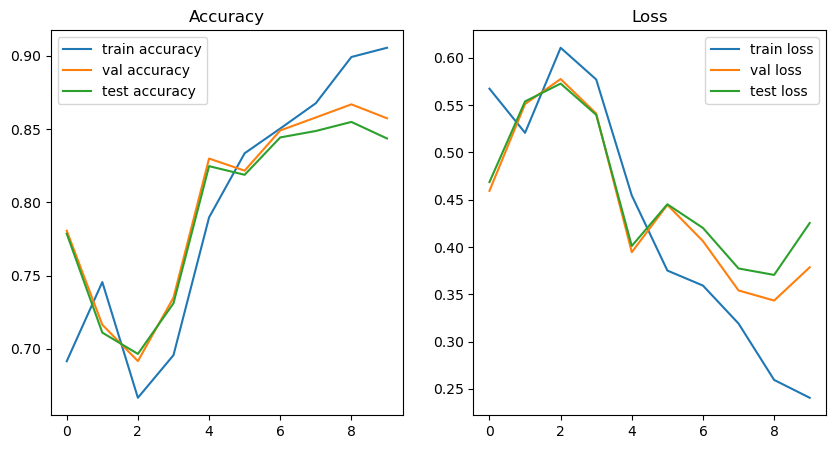

In [271]:
lr = 5e-4
vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 300
output_dim = NUM_CLASSES
print('output dim = ', output_dim)
n_layers = 2
bidirectional = True
dropout_rate = 0.5

model = GRUClassification(
    vocab_size,
    embedding_dim,
    hidden_dim,
    output_dim,
    n_layers,
    bidirectional,
    dropout_rate,
    pad_id,
)

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

tune(model, optimizer, criterion)

# Hyperparms tuning #1, hidden_dim = 500

In [272]:
lr = 5e-4
vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 500
output_dim = NUM_CLASSES
print('output dim = ', output_dim)
n_layers = 2
bidirectional = True
dropout_rate = 0.5

model = LSTM(
    vocab_size,
    embedding_dim,
    hidden_dim,
    output_dim,
    n_layers,
    bidirectional,
    dropout_rate,
    pad_id,
)

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

tune(model, optimizer, criterion)

output dim =  2
The model has 19,805,602 trainable parameters
['<unk>', '<pad>', 'the', '.', ',', 'a', 'and', 'of', 'to', "'", 'is', 'it', 'i', 'in', 'this', 'that', 's', 'was', 'movie', 'as', 'with', 'for', 'but', 'film', ')', '(', 'you', 'on', 't', 'not', 'are', 'have', 'his', 'one', 'he', 'be', '!', 'at', 'all', 'they', 'by', 'an', 'who', 'so', 'from', 'like', 'there', 'about', 'just', 'or', 'has', 'if', 'out', 'what', 'her', 'some', '?', 'good', 'very', 'can', 'when', 'my', 'more', 'time', 'story', 'she', 'no', 'would', 'even', 'really', 'up', 'see', 'only', 'had', 'me', 'which', 'were', 'their', 'we', 'bad', 'well', 'great', 'much', 'people', 'first', '-', 'than', 'been', 'get', 'other', 'how', 'don', 'do', 'because', 'most', 'will', 'into', 'movies', 'also', 'made', 'its', 'could', 'then', 'him', 'them', 'make', 'way', 'after', 'characters', 'watch', 'seen', 'too', 'think', 'any', 'plot', 'acting', 'films', 'many', 'love', 'show', 'character', 'two', 'ever', 'best', 'did', 'being

evaluating...: 100%|██████████| 98/98 [00:12<00:00,  8.10it/s]


epoch: 0
train_loss: 0.613, train_acc: 0.672
val_loss: 0.469, valid_acc: 0.799
test_loss: 0.478, test_acc: 0.789


evaluating...: 100%|██████████| 98/98 [00:12<00:00,  8.14it/s]


epoch: 1
train_loss: 0.588, train_acc: 0.694
val_loss: 0.517, valid_acc: 0.746
test_loss: 0.528, test_acc: 0.736


training...:  92%|█████████▏| 73/79 [00:26<00:02,  2.84it/s]